# Generation of hyperspectral samples using Wasserstein-GANs

Wasserstein-GANs are Generative Adversarial Models that can be used to generate synthetic data that approximates a specific input distribution of real data.

In this notebook, we show how to use such a tool to generate *ex nihilo* synthetic hyperspectral samples.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
import spectral

We load the Pavia University dataset. The `.mat` files are available on [this website](http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes).

In [2]:
import os

current_dir = os.getcwd()
# 构建 PaviaU.mat 文件的路径
file_path = os.path.join(current_dir, 'PaviaU.mat')

if not os.path.exists(file_path):
    print("文件不存在")
else:
    print("文件存在")
    
file_path = os.path.join(current_dir, 'paviaU_gt.mat')
if not os.path.exists(file_path):
    print("文件不存在")
else:
    print("文件存在")

文件存在
文件存在


In [3]:

current_dir = os.getcwd()

# 构建 PaviaU.mat 和 PaviaU_gt.mat 文件的路径
paviaU_path = os.path.join(current_dir,'PaviaU.mat')
paviaU_gt_path = os.path.join(current_dir,'PaviaU_gt.mat')

# 读取数据
img = loadmat(paviaU_path)['paviaU']
gt = loadmat(paviaU_gt_path)['paviaU_gt']

# 输出数据以确认成功加载
print("img:", img)
print("gt:", gt)

img: [[[ 647  499  464 ... 3221 3238 3250]
  [ 604  546  527 ... 2442 2464 2528]
  [ 621  746  556 ... 2308 2345 2361]
  ...
  [ 524  525  598 ... 2936 2940 2950]
  [ 528  330   70 ... 2737 2774 2829]
  [ 711  483  423 ... 2562 2539 2488]]

 [[ 705  681  668 ... 2607 2607 2609]
  [ 891  692  453 ... 1581 1561 1522]
  [ 547  511  604 ... 1535 1531 1538]
  ...
  [1149  658  434 ... 3247 3251 3277]
  [ 917 1004  743 ... 2828 2806 2808]
  [1037  849  547 ... 2491 2527 2522]]

 [[1084  875  706 ... 2108 2167 2183]
  [ 335  517  611 ... 1105 1109 1095]
  [1042  683  318 ...  806  791  814]
  ...
  [ 799  693  481 ... 2761 2791 2842]
  [ 226  350  613 ... 2885 2879 2859]
  [ 828  571  479 ... 2799 2809 2806]]

 ...

 [[ 733  617  708 ... 2190 2189 2176]
  [ 785  796  979 ... 1963 1983 1972]
  [ 826  828  928 ... 1905 1939 1965]
  ...
  [ 704  710  689 ... 2401 2385 2349]
  [ 376  305    0 ... 2449 2448 2429]
  [1146  919  707 ... 2504 2541 2523]]

 [[ 785  727  871 ... 2166 2179 2178]
  [ 856

The ground truth is shown below. We sample 10% from the pixels as training samples.



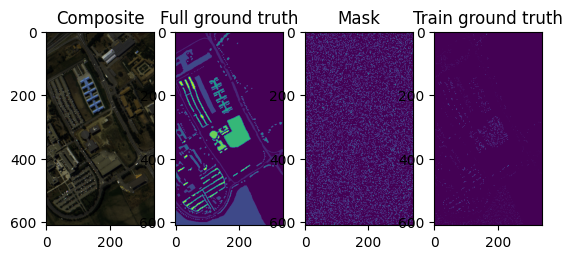

In [4]:
# 生成随机掩码，用于选择训练数据
# mask会是一个与gt形状相同的布尔数组，其中随机约5%的位置为True（True意味着选择这些样本）
mask = np.random.randint(0, 100, gt.shape) < 5

# 复制地面真值(gt)，以便创建训练样本
train_gt = np.copy(gt)

# 使用布尔掩码更新训练地面真值
# 把mask为False的位置（即gt中不属于训练样本的位置）设置为0
train_gt[np.nonzero(~mask)] = 0

# 复制地面真值(gt)，以便创建测试样本
test_gt = np.copy(gt)

# 使用训练地面真值更新测试地面真值
# 把训练集中的样本（train_gt > 0）在测试集中的对应值设置为0，
# 这样做的目的是确保训练集和测试集之间没有重叠
test_gt[train_gt > 0] = 0

rgb = img[:,:,(55,41,12)]
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)
plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

We define a `HyperX` class to hold the dataset. Note that the label is encoded as a one-hot vector.

In [5]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):

    def __init__(self, data, ground_truth, semi=False):
        #data_loader = torch.utils.data.DataLoader(HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
        super(HyperX, self).__init__()

        # 数值归一化，将数据规范化到[0, 1]之间
        data = (data - data.min()) / (data.max() - data.min())  # 归一化逻辑
        self.data = data  # 存储高光谱数据
        self.gt = ground_truth  # 存储地面真值数据
        self.n_classes = len(np.unique(ground_truth))
        # ground_truth通常是一个二维数组
        # np.unique(ground_truth)会生成一个一维数组，包含ground_truth中出现的所有不同的、唯一的值

        if semi:
            # 如果是半监督学习，使用膨胀操作提取邻域索引，半径为50像素
            # morphology.disk(50) 创建半径为50的圆形结构元素
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
            #在这里，它会返回膨胀后布尔数组中所有为True（或者等价于1）的元素的坐标
            #就是返回ground_truth大于0的点以及周围的点
        else:
            # 否则仅使用非零地面真值的位置
            x_pos, y_pos = np.nonzero(ground_truth)

        # 将(x, y)坐标索引组合成列表，用于访问数据
        self.indices = [idx for idx in zip(x_pos, y_pos)]

    def __len__(self):
        # 返回数据集中样本的数量（即索引的数量）
        return len(self.indices)

    def __getitem__(self, i):
        # 根据索引获取样本的坐标
        x, y = self.indices[i]

        # 假设提取 5x5 的图像块（可根据需要调整大小）
        k = 32  # 选取一个 5x5 的区域（中心是 (x, y)）

        # 确保不会越界
        x_start = max(0, x - k)
        x_end = min(self.data.shape[0], x + k + 1)  # 保证不越界
        y_start = max(0, y - k)
        y_end = min(self.data.shape[1], y + k + 1)  # 保证不越界

        data = self.data[x_start:x_end, y_start:y_end, :]  # 选取区域

        # 确保大小相同，填充或裁剪至相同大小
        expected_size = (65, 65)  # 预期的 (height, width)
        data_shape = data.shape[0:2]  # (height, width)
        if data_shape != expected_size:
            # 如果不相等，则需要填充（或裁剪）
            data = np.pad(data, ((0, expected_size[0] - data_shape[0]),
                                 (0, expected_size[1] - data_shape[1]),
                                 (0, 0)), mode='constant')  # 用零填充
            # 如果你选择裁剪应确保 data 形状不超过 (5, 5)

        data = data.transpose(2, 0, 1)  # 将形状从 (height, width, channels) 转换为 (channels, height, width)

        # 获取相应位置的标签
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')

        # 将数据和标签转换为 PyTorch 的 tensor
        return torch.from_numpy(data), torch.from_numpy(label)

In [6]:
import os
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# 基本生成器：将噪声 + 条件输入映射为生成样本
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim, c_dim, h_dim):
        super(Generator, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(z_dim + c_dim, h_dim),
            nn.BatchNorm1d(h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, h_dim * 8),  # 将 h_dim 扩展到 h_dim * 8
            nn.BatchNorm1d(h_dim * 8),
            nn.LeakyReLU(),
        )

        self.init_size = h_dim // 4
        self.l1 = nn.Linear(h_dim * 8, 128 * 8 * 8)  # 修改为较小的中间形状

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),    # 输入 (batch_size, 128, 8, 8) -> 输出 (batch_size, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 输入 (batch_size, 64, 16, 16) -> 输出 (batch_size, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),     # 输入 (batch_size, 32, 32, 32) -> 输出 (batch_size, 16, 64, 64)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(16, 103, kernel_size=4, stride=2, padding=1),    # 输入 (batch_size, 16, 64, 64) -> 输出 (batch_size, 103, 128, 128)
            nn.Tanh()  # 使用 Tanh 激活函数以生成最终图像
        )

    def forward(self, z, c):
        inputs = torch.cat([z, c], 1)  # inputs: (batch_size, z_dim + c_dim)
        x = self.linear(inputs)  # x: (batch_size, h_dim * 8)
        x = self.l1(x).view(-1, 128, 8, 8)  # 为卷积层做准备  (batch_size, 128, 8, 8)
        x = self.deconv(x)  # (batch_size, 3, 128, 128)

        # 然后我们可以插值至最终输出大小 (65, 65)
        x = nn.functional.interpolate(x, size=(65, 65), mode='bilinear', align_corners=False)  # (batch_size, 3, 65, 65)
        return x


# 基本判别器：样本 -> -∞（假） - 0 - 真实（+∞）
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),   # 输入 (input_channels, 65, 65) -> 输出 (32, 33, 33)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),                # 输入 (32, 33, 33) -> 输出 (64, 17, 17)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),              # 输入 (64, 17, 17) -> 输出 (128, 9, 9)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),             # 输入 (128, 9, 9) -> 输出 (256, 5, 5)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten()  # 展平成一维向量
        )

        # 动态获取展平后的特征维度
        example_input = torch.rand(1, input_channels, 65, 65)  # 使用与实际输入相同的大小
        with torch.no_grad():
            example_output = self.conv_layers(example_input)
        flat_feature_dim = example_output.view(-1).shape[0]  # 根据具体输出计算特征维度

        self.fc = nn.Sequential(
            nn.Linear(flat_feature_dim, 512),  # 降低全连接层的大小
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, X):
        # X 应为 (batch_size, input_channels, height, width)
        X = self.conv_layers(X)  # 通过卷积层
        X = self.fc(X)  # 通过全连接层
        return X

# 基本分类器：样本 -> 类别
class Classifier(nn.Module):
    def __init__(self, input_channels, c_dim, h_dim):
        super(Classifier, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),  # 输入 (input_channels, 65, 65) -> 输出 (32, 33, 33)
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),              # 输出 (64, 17, 17)
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),             # 输出 (128, 9, 9)
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),            # 输出 (256, 5, 5)
            nn.LeakyReLU(),
            nn.Flatten()  # 会展平为 (batch_size, 256 * H * W)
        )

        # 动态获取展平后的特征维度
        example_input = torch.rand(1, input_channels, 65, 65)  # 使用适当的输入大小
        with torch.no_grad():
            example_output = self.conv_layers(example_input)
        flat_feature_dim = example_output.view(-1).shape[0]  # 得到展平特征的数量

        # 定义全连接层
        self.discriminator = nn.Sequential(
            nn.Linear(flat_feature_dim, h_dim),  # 使用合适的隐藏层维度
            nn.LeakyReLU(),
            nn.Linear(h_dim, c_dim)  # 最后一层输出类别数
        )

        # 应用权重初始化
        self.apply(self.weight_init)

    def weight_init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, 0.0, 0.02)  # 使用正态分布初始化权重
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0.0, 0.02)  # 使用正态分布初始化权重
            nn.init.constant_(m.bias, 0)  # 初始偏置为 0

    def forward(self, X):
        # X 输入的形状为 (batch_size, input_channels, height, width)
        X = self.conv_layers(X)  # 通过卷积层
        return self.discriminator(X)  # 通过全连接层进行分类


In [7]:
# 设置训练参数
mb_size = 5           # 批次大小，表示每次训练所使用的样本数量
z_dim = 30               # 噪声的维度，表示随机噪声的长度
X_dim = img.shape[-1]   # 输入样本的特征维度，通常是图像的波段数量
h_dim = 128            # 隐藏层的尺寸，定义网络中隐藏层的节点数量
d_step = 5            # 每个生成器训练步骤前判别器训练的步骤数
lr = 5e-5                # 学习率，控制权重更新的步长
c_weight = 0.2           # 辅助分类器的权重，平衡生成器与分类器的损失
flip_percentage = 0.0    # 标签翻转比例，用于半监督学习时的数据增强
mixup_alpha = 0.1        # Mixup的超参数，用于样本混合和数据增强
semi_supervised = True    # 半监督学习（若设置为True，则包含未标记样本进行训练）

# 构建数据集和数据加载器
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)

# c_dim = 条件向量的大小，即类别数量
c_dim = data_loader.dataset.n_classes

print("c_dim:", c_dim)

# 忽略类别0（通常为背景或未标记类）
class_weights = torch.ones((c_dim))  # 创建一个大小为c_dim的全1的权重张量
class_weights[0] = 0.                 # 将类别0的权重设为0，以避免影响训练
class_weights = class_weights.cuda()   # 将权重张量移动到GPU（如果使用CUDA）

c_dim: 10


In [8]:
# 使用He et al. (2015)策略初始化权重
def weight_init(m):
    # 判断模块类型，如果是线性层或卷积层或转置卷积层，初始化权重
    if isinstance(m, (nn.Linear)):
        # 对线性层使用 Kaiming 初始化
        torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='linear')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)  # 初始化偏置为0

    elif isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        # 对二维卷积层和转置卷积层使用 Kaiming 初始化
        torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)  # 初始化偏置为0

    elif isinstance(m, (nn.Conv3d, nn.ConvTranspose3d)):
        # 对三维卷积层和转置卷积层使用 Kaiming 初始化
        torch.nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)  # 初始化偏置为0

    # 你可以根据需要扩展到其他层类型，例如 BatchNorm、LayerNorm 等
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)  # 权重初始化为1
        nn.init.constant_(m.bias.data, 0)    # 偏置初始化为0
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)  # 权重初始化为1
        nn.init.constant_(m.bias.data, 0)    # 偏置初始化为0


# 在单位超球面上进行球面插值
# 参考链接: https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    # 计算low和high之间的夹角ω
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)  # 计算sin(ω)

    if so == 0:
        # 如果so为0，表示两个向量方向相同，返回线性插值
        return (1.0-val) * low + val * high  # L'Hôpital法则/LERP

    # 进行球面线性插值计算
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

# 线性插值函数
def lerp(val, low, high):
    return (1.0-val) * low + val * high  # L'Hôpital法则/LERP

# 计算改进WGAN训练中的梯度惩罚
# 来源: https://github.com/EmilienDupont/wgan-gp
# 使用建议的惩罚权重设为10
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
    #netD是一个判别器

    batch_size = real_data.size()[0]  # 获取真实数据的批次大小

    # alpha取值在0到1之间，用于插值
    alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
    #如果 real_data.dim() == 2 返回 [batch_size, 1] ，否则返回 [batch_size, 1, 1, 1]
    alpha = alpha.expand_as(real_data)  # 与真实数据形状相同
    #用于返回一个形状与另一张量相同但共享同一数据的新的张量
    alpha = alpha.cuda()  # 将alpha转移到GPU上

    # 进行插值，生成混合样本
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    interpolated.requires_grad_()  # 需要计算梯度
    interpolated = interpolated.cuda()  # 转移到GPU上

    # 计算插值样本的概率
    prob_interpolated = netD(interpolated)

    # 计算插值样本的概率的梯度
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                                    create_graph=True, retain_graph=True)[0]

    # 将梯度形状转换为(batch_size, num_features)
    gradients = gradients.view(batch_size, -1)

    # 计算梯度的范数，防止接近0的情况引发问题，加入微小值epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # 返回梯度惩罚
    return penalty_weight * ((gradients_norm - 1) ** 2).mean()

# 重置多个网络的梯度
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()  # 清零每个网络的梯度

# 绘制样本的均值与标准差
def plot_mean_std(samples):
    # 计算每个通道的均值和标准差，axis=0 表示对样本维度进行操作
    mean_spectrum = np.mean(samples, axis=0)  # shape: (103, 65, 65)
    std_spectrum = np.std(samples, axis=0)    # shape: (103, 65, 65)

    # 随机选择一个通道
    random_channel = np.random.choice(mean_spectrum.shape[0])  # 随机选择一个在[0, 102]范围内的整数

    # 创建图形
    plt.figure(figsize=(12, 6))

    # 绘制均值和标准差曲线
    plt.plot(mean_spectrum[random_channel].flatten(), label='Mean (Channel {})'.format(random_channel), alpha=0.7)  # 绘制均值
    plt.plot((mean_spectrum[random_channel] - std_spectrum[random_channel]).flatten(), linestyle='dotted', label='Mean - Std (Channel {})'.format(random_channel))  # 绘制均值-标准差
    plt.plot((mean_spectrum[random_channel] + std_spectrum[random_channel]).flatten(), linestyle='dotted', label='Mean + Std (Channel {})'.format(random_channel))  # 绘制均值+标准差

    plt.title('Channel {}'.format(random_channel))
    plt.xlabel('Spatial Location (flattened)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid()
    plt.show()  # 显示图形

def visualize_selected_columns(pred, selected_indices=[55, 41, 12], normalize=True):
    """
    选择指定通道并进行归一化，最终将结果可视化为图像。
    
    参数:
    - pred: 一个形状为(5, 103, 64, 64)的PyTorch张量，生成的高光谱图像。
    - selected_indices: 需要选择的通道索引列表，例如 [55, 41, 12]。
    - normalize: 布尔值，指示是否进行归一化。
    """
    # 选择指定的通道
    selected_channels = pred[:, selected_indices, :, :]  # 选择指定的通道，形状为 (5, 3, 64, 64)

    # 将选定的通道转换为 NumPy 数组并进行处理
    rgb = selected_channels.detach().cpu().numpy()  # 确保在CPU上并转为NumPy
    rgb = np.transpose(rgb, (0, 2, 3, 1))  # 变换维度为 (5, 64, 64, 3)，把通道放到最后

    # 可视化每个批次的图像
    for i in range(rgb.shape[0]):  # 遍历每个批次
        img = rgb[i]  # 取出当前批次的图像

        # 进行归一化
        if normalize:
            img = 255 * (img.astype(np.float32) - img.min()) / (img.max() - img.min())
            img = img.astype(np.uint8)

        # 可视化
        plt.figure(figsize=(6, 6))
        plt.imshow(img)  # 直接显示 RGB 图像
        plt.axis('off')  # 关闭坐标轴
        plt.title(f'Visualized RGB Image from Selected Channels of Batch {i + 1}')
        plt.show()


  0%|          | 0/100000 [00:00<?, ?it/s]

Iter-0; D_loss: -1.843687891960144; G_loss: 3.048020362854004; C_loss: 1.8812553882598877


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30480\1747427471.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.log_softmax(C(X))  # 对真实样本应用log_softmax


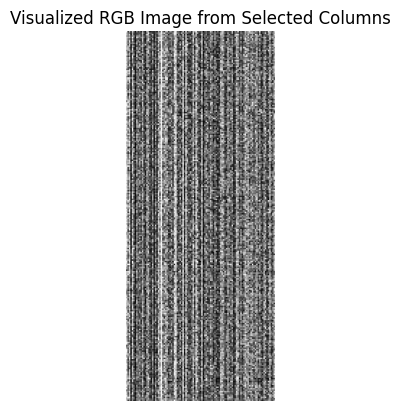

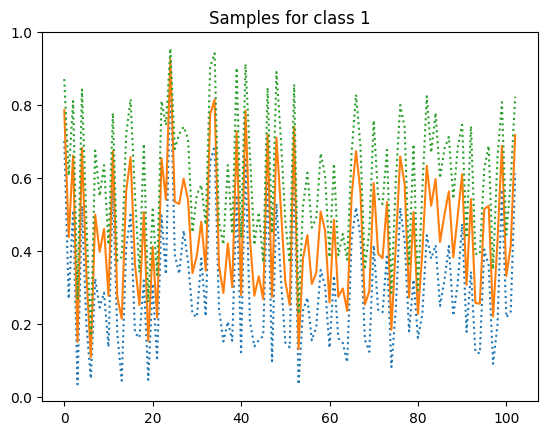

  1%|          | 999/100000 [00:54<1:27:33, 18.84it/s]

Iter-1000; D_loss: -0.18210485577583313; G_loss: -0.3968060314655304; C_loss: 0.1833178848028183


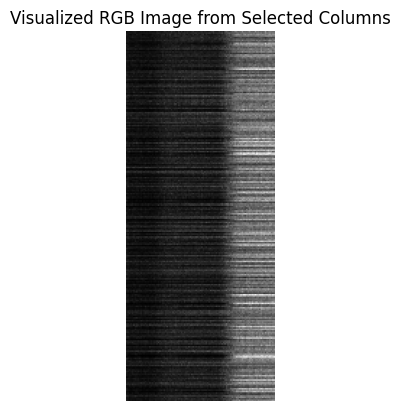

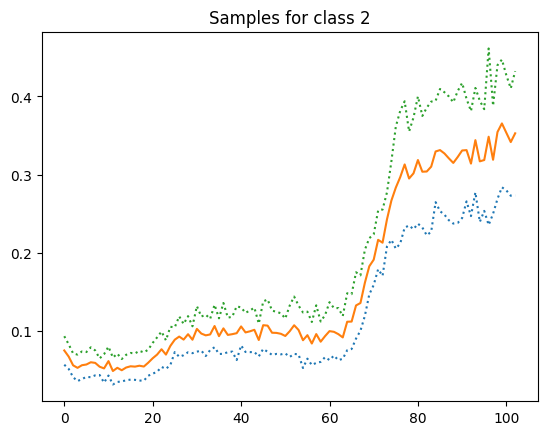

  2%|▏         | 1999/100000 [01:48<1:30:43, 18.00it/s]

Iter-2000; D_loss: -0.1811647117137909; G_loss: -0.161147803068161; C_loss: 0.06281697750091553


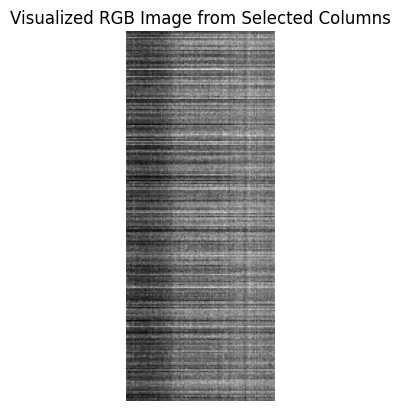

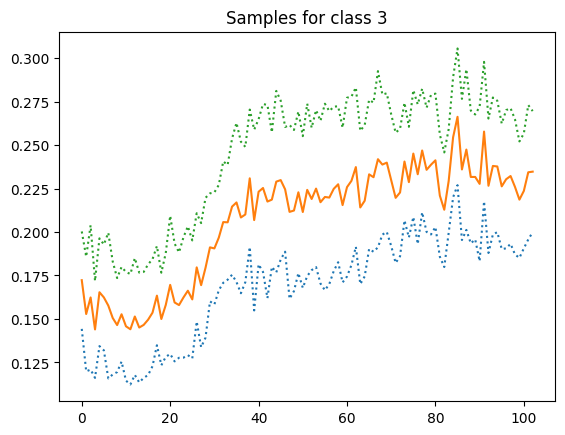

  2%|▏         | 2169/100000 [01:58<1:29:04, 18.30it/s]


KeyboardInterrupt: 

In [9]:
# 实例化生成器、判别器和分类器并移动到GPU
G = Generator(z_dim, c_dim, h_dim).cuda()  # 生成器
D = Discriminator(X_dim).cuda()  # 判别器
C = Classifier(X_dim, c_dim, h_dim).cuda()  # 分类器

# 使用RMSProp优化器
G_solver = optim.RMSprop(G.parameters(), lr=lr)  # 为生成器设置RMSprop优化器
D_solver = optim.RMSprop(D.parameters(), lr=lr)  # 为判别器设置RMSprop优化器
C_solver = optim.RMSprop(C.parameters(), lr=lr)  # 为分类器设置RMSprop优化器

# 创建保存图片的目录
output_dir = os.path.join(current_dir, '111')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
    batch_size = y.size(0)

    X, y = X.float().cuda(), y.float().cuda()
    X_, y_ = X_.float().cuda(), y_.float().cuda()
    print("Current Batch Size:", batch_size)
    print("X shape:", X.shape)
    print("y shape:", y.shape)

    print("X_ shape:", X_.shape)
    print("y_ shape:", y_.shape)

    print("-" * 50)  # 分隔线，便于视觉分隔不同的迭代输出


# 开始训练迭代
for it in tqdm(range(100000)):  #requires_grad成员和.parameters()方法是属于nn.Module 的类的
    ###########################
    # (1) 更新分类器C和判别器D #
    ###########################
    for p in D.parameters():  # 重置D参数的requires_grad  
        p.requires_grad = True  # D的参数需要梯度
    for p in C.parameters():
        p.requires_grad = True  # C的参数需要梯度

    # 每次迭代训练d_step次判别器
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        # 确保你的 X 和 X_ 是形状为 (batch_size, channels, height, width)  X shape: torch.Size([256, 103, 5, 5])
        # 由于X和X_是3D张量，shape 应该是 (batch_size, channels, height, width)  y shape: torch.Size([256, 10])

        # 获取批处理大小
        batch_size = y.size(0)  # 标签的数量，也就是当前batch的大小

        # 采样随机噪声
        z = torch.randn(batch_size, z_dim).cuda()  # 随机噪声, z_dim = 30, 移动到GPU

        # 将输入数据转为float类型并移动到GPU
        X, y = X.float().cuda(), y.float().cuda()
        X_, y_ = X_.float().cuda(), y_.float().cuda()  # 处理第二批数据

        # Mixup 数据增强
        lam = np.random.beta(mixup_alpha, mixup_alpha)  # 从Beta分布中抽样

        # 计算 Mixup 样本，确保 X 的shape应为 (batch_size, channels, height, width) 和 X_ 一致
        X_mixed = lam * X + (1. - lam) * X_  # 生成混合样本

        # 由于 X_mixed 是三维张量，可能需要对其进行 flatten 操作以适应后续模型处理（如果需要）
        # 如果后续模型需要展平，可以使用以下代码：
        # X_mixed = X_mixed.view(batch_size, -1)  # 将其展平为 (batch_size, channels * height * width)

        # 清空判别器的梯度
        D.zero_grad()

        # 判别器对真实样本的预测
        D_real = D(X).mean()  #一个用于计算张量元素平均值的方法  (256, 1)
        # 判别器对生成样本的预测
        fake_samples = G(z, y)  # 使用生成器生成假样本  z是噪声，y是label
        D_fake = D(fake_samples).mean()

        # 计算梯度惩罚
        gradient_penalty = calc_gradient_penalty(D, X.detach(), fake_samples.detach())

        # 计算判别器损失并反向传播
        D_loss = D_fake - D_real + gradient_penalty
        # WGAN中的损失计算  D_loss 的目标是最大化判别器对真实样本的评分并最小化对生成样本的评分。
        flip = np.random.random() < flip_percentage  # 随机决定是否翻转标签
        if flip:
            # 翻转真实和假样本
            gradient_penalty = calc_gradient_penalty(D, fake_samples.detach(), X.detach())
            D_loss = D_real - D_fake + gradient_penalty

        D_loss.backward()  # 反向传播
        D_solver.step()  # 更新判别器参数

        ######################
        #  更新分类器C网络  #
        ######################
        C.zero_grad()  # 清空分类器的梯度
        # 获取类标签
        _, classes = torch.max(y, dim=1)  #y的形状通常为 (batch_size, num_classes)
        _, classes_ = torch.max(y_, dim=1)
        # 获取分类器的预测
        if flip:
            fake_samples = G(z, y)  # 生成假样本
            pred = C(fake_samples)  # 分类器对假样本的预测
            # 计算分类器损失并反向传播
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))  # 对真实样本应用log_softmax
            # 计算分类器损失（Mixup损失计算）
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)

        C_loss.backward()  # 反向传播
        C_solver.step()  # 更新分类器参数


    ############################
    # (2) 更新生成器G网络     #
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # 禁用判别器的参数计算，以避免梯度回传
    for p in C.parameters():
        p.requires_grad = False  # 禁用分类器的参数计算

    reset_grad(C, G, D)  # 重置梯度

    # 采样随机噪声
    z = torch.randn(y.size(0), z_dim).squeeze()  # 随机噪声
    z = z.cuda()  # 移动到GPU
    # 生成假样本
    G_sample = G(z, y)
    D_fake = D(G_sample)  # 判别器对生成样本的预测
    pred = C(G_sample)  # 分类器对生成样本的预测
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)  # 计算分类器损失
    # 计算生成器损失以愚弄判别器 (WGAN)
    G_loss = -torch.mean(D_fake)  # WGAN生成器损失
    # 包括辅助分类器损失 (AC-GAN)
    loss = G_loss + c_weight * C_loss  # 总损失
    # 反向传播
    loss.backward()
    G_solver.step()  # 更新生成器参数

    # 每隔一定迭代次数打印和可视化结果
    if it % 1000 == 0:
        with torch.no_grad():
            # 打印当前损失
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                                       D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                                       C_loss.data.cpu().numpy()))
            # 采样生成图像
            z = torch.randn(mb_size, z_dim).squeeze().cuda()  # 随机噪声  生成的张量会有 mb_size 行和 z_dim 列，其中的每一个元素来自正态分布的随机数
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')  # 创建类标签  mb_size = 256  z_dim = 30  c_dim= 数组的形状为 (mb_size, c_dim)
            idx = np.random.randint(1, data_loader.dataset.n_classes)  # 随机选择一个类
            c[:, idx] = 1.  # 设置为对应类
            c = torch.from_numpy(c).squeeze().cuda()  # 转为torch tensor并移动到GPU

            pred = G(z, c)  # 生成器生成的样本
            samples = pred.data.cpu().numpy()[:16]  # 生成样本

            visualize_selected_columns(pred)

            plot_mean_std(samples)  # 绘制生成样本
            plt.title("Samples for class {}".format(idx))  # 显示标题
            plt.show()  # 展示图像


## Data generation

Now that the generator has been trained, we can generate some fake spectra and see how they fare visually against the real ones.

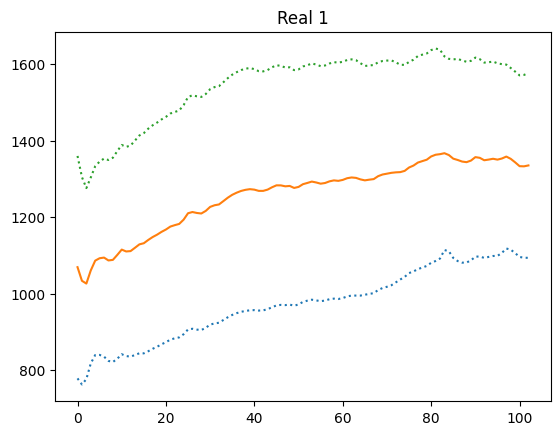

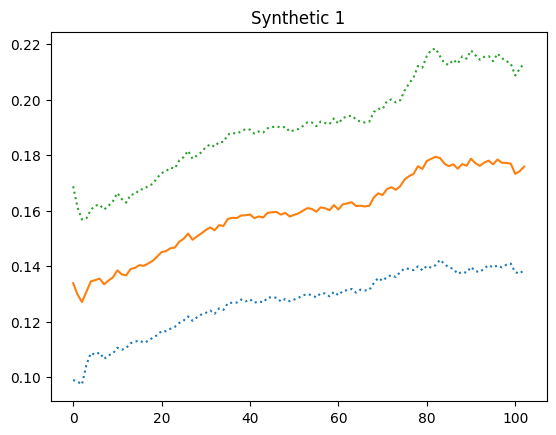

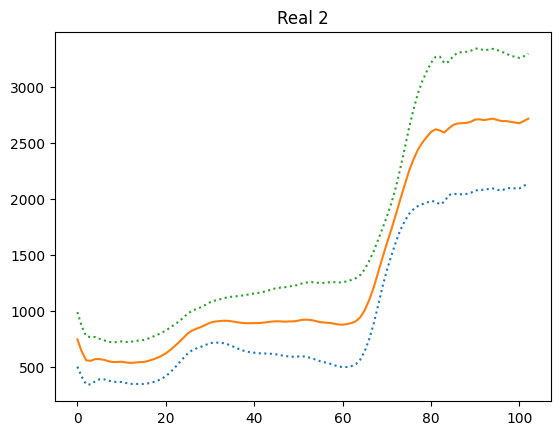

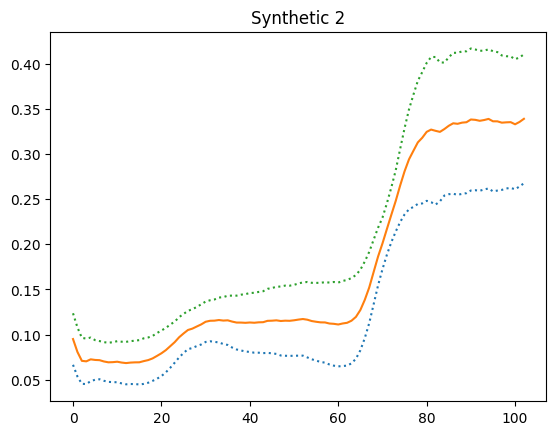

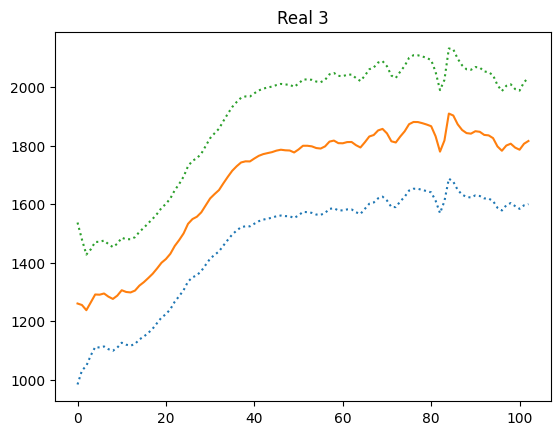

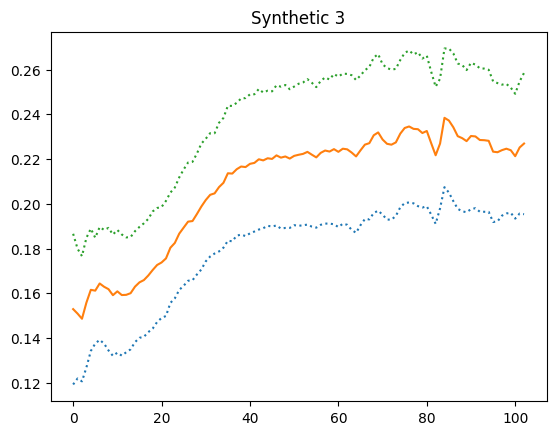

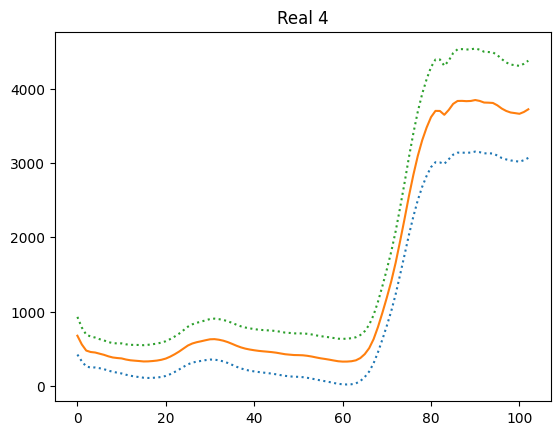

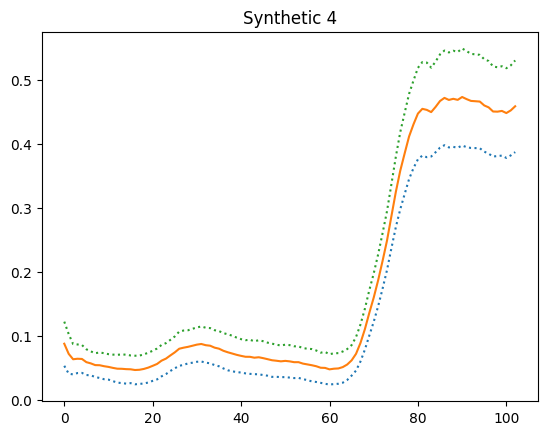

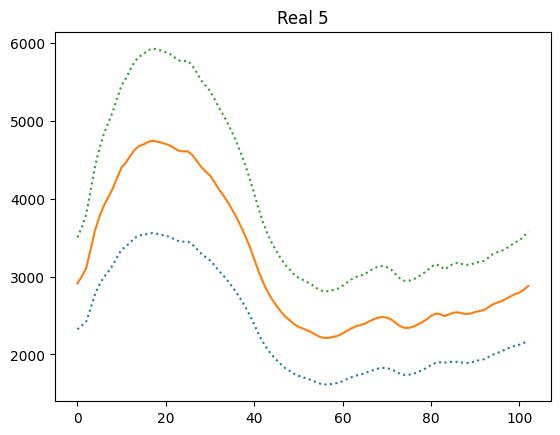

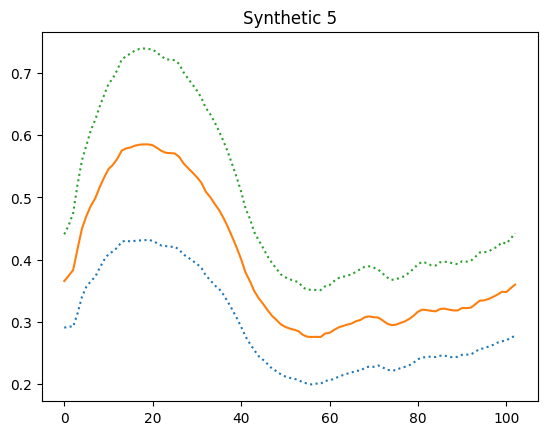

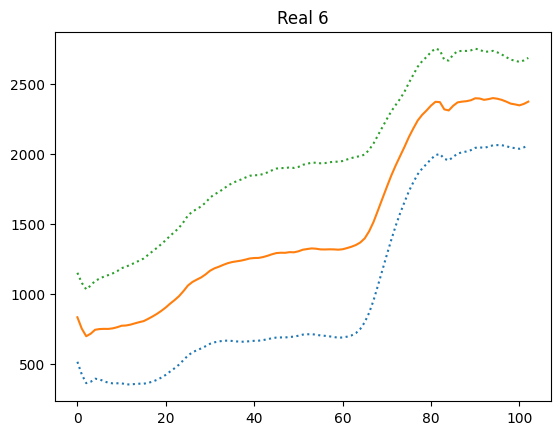

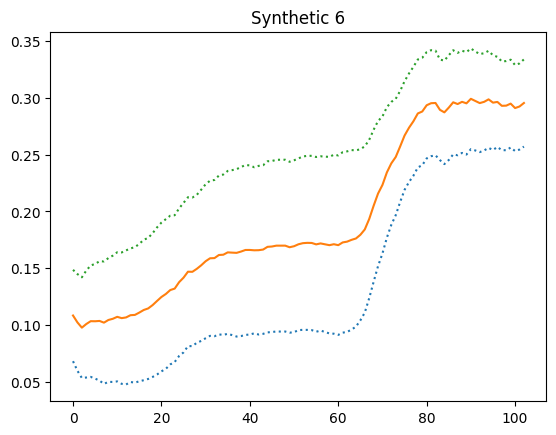

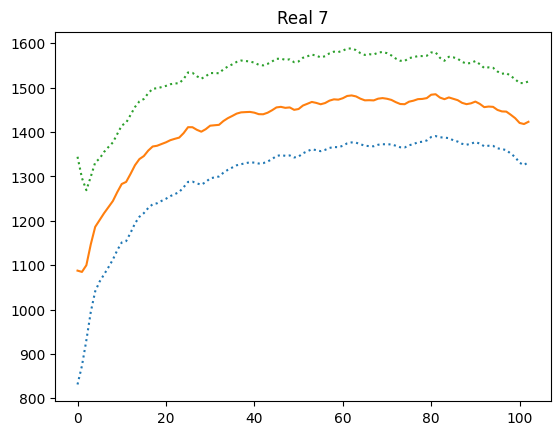

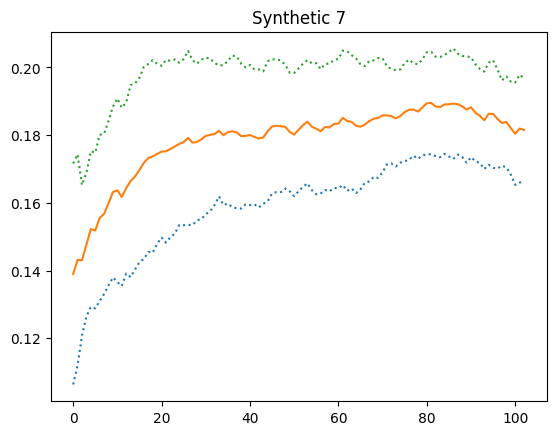

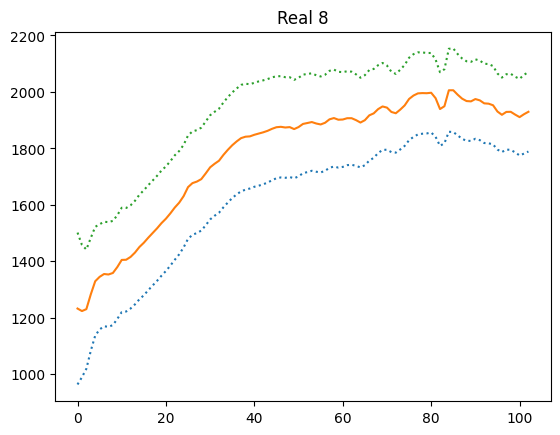

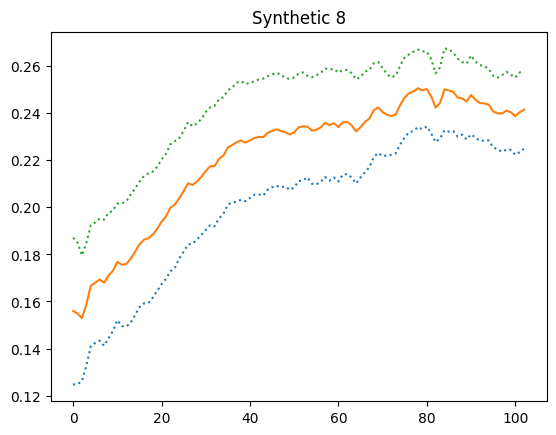

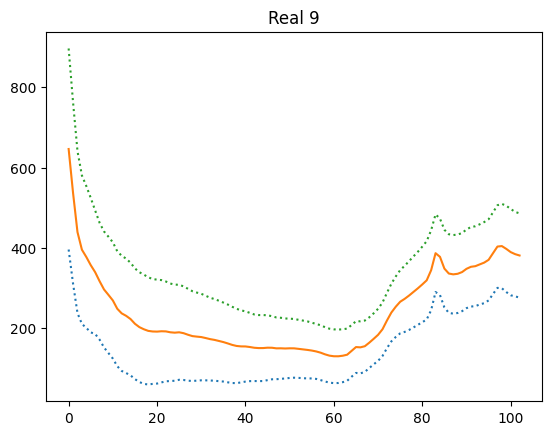

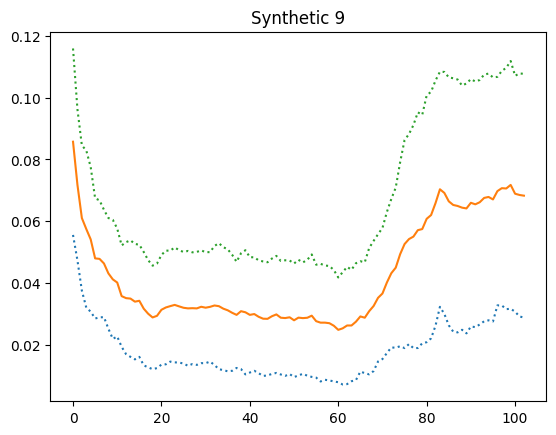

In [18]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

## Evaluation

Finally, we want to compare the two distributions: is the fake distribution truely similar to the real distribution? To this end, we first can train a linear SVM on the real data and then apply it on the fake data. The frontiers of the real data should be respected by the fake data if the learning was successful.

In [19]:
import sklearn.svm
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.mixture

In [20]:
img = (img - img.min()) / (img.max() - img.min())
X_train = np.array([img[x,y] for x,y in zip(*np.nonzero(train_gt))])
y_train = np.array([gt[x,y] for x,y in zip(*np.nonzero(train_gt))])
X_test = np.array([img[x,y] for x,y in zip(*np.nonzero(test_gt))])
y_test = np.array([test_gt[x,y] for x,y in zip(*np.nonzero(test_gt))])

In [21]:
gmms = [sklearn.mixture.GaussianMixture(n_components=20) for _ in range(c_dim)]
for y in np.unique(y_train):
    gmms[y].fit(X_train[y_train == y])

We can uncomment this code to use Gaussian Mixture Models instead of GANs.

In [22]:
def gmm_create_fake_dataset(gmms, y):
    fake_X = []
    y_fake = []
    for y in np.unique(y):
        n_samples = np.count_nonzero(y_test == y)
        samples = gmms[y].sample(n_samples)[0]
        fake_X.append(samples)
        y_fake += [y] * n_samples
    fake_X = np.concatenate(fake_X)
    y_fake = np.array(y_fake)
    return fake_X, y_fake

#fake_X_train, fake_y_train = gmm_create_fake_dataset(gmms, y_train)
#fake_X_test, fake_y_test = gmm_create_fake_dataset(gmms, y_test)

### SVM on real data

Let's train a linear SVM on real data and see how it performs.

In [23]:
scaler = sklearn.preprocessing.StandardScaler()
svm = sklearn.svm.SVC()
#estimator = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm)])
estimator = sklearn.pipeline.Pipeline(steps=[('svm', svm)])
#tuned_parameters = {'svm__C': [0.1, 1, 10, 100, 1000], 'svm__kernel': ['linear']}
tuned_parameters = {'svm__C': [1000], 'svm__kernel': ['linear']}
clf = sklearn.model_selection.GridSearchCV(estimator, tuned_parameters, cv=5, n_jobs=4)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
best_params = clf.best_params_
print("The best SVM was obtained using {} and performed at {:.2f} accuracy.".format(best_params, 100 * score))

The best SVM was obtained using {'svm__C': 1000, 'svm__kernel': 'linear'} and performed at 90.17 accuracy.


In [24]:
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.89      0.92      0.90      6310
           2       0.93      0.96      0.95     17712
           3       0.81      0.75      0.78      1990
           4       0.92      0.90      0.91      2903
           5       0.98      0.99      0.99      1277
           6       0.87      0.79      0.83      4764
           7       0.78      0.62      0.69      1269
           8       0.82      0.86      0.84      3505
           9       1.00      1.00      1.00       894

    accuracy                           0.90     40624
   macro avg       0.89      0.87      0.88     40624
weighted avg       0.90      0.90      0.90     40624



### SVM on fake data

We now generate some fake data (in the same quantities as the real data) and apply the trained SVM on it.

In [25]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [26]:
fake_X_train, fake_y_train = gan_create_fake_dataset(y_train)
fake_X_test, fake_y_test = gan_create_fake_dataset(y_test)

The true SVM performs better on fake data. Fake data is easier to separate, which means that it does not capture well boundaries between classes.

In [27]:
clf.score(fake_X_test, fake_y_test)

0.9464109885781804

In [28]:
y_fake_pred = clf.predict(fake_X_test)
from sklearn.metrics import classification_report
print(classification_report(fake_y_test, y_fake_pred))

              precision    recall  f1-score   support

           1       0.96      0.92      0.94      6310
           2       0.98      0.97      0.97     17712
           3       0.97      0.93      0.95      1990
           4       0.98      0.98      0.98      2903
           5       0.97      0.99      0.98      1277
           6       0.84      0.91      0.87      4764
           7       0.95      0.81      0.88      1269
           8       0.88      0.95      0.91      3505
           9       1.00      0.91      0.95       894

    accuracy                           0.95     40624
   macro avg       0.95      0.93      0.94     40624
weighted avg       0.95      0.95      0.95     40624



We can also train a "fake" SVM on fake data. It separates the fake data nearly perfectly. However, it also neatly separates the true data. It is not as good as the true SVM, but still relatively good for synthetic data.

In [29]:
svm_fake = sklearn.svm.SVC()
clf_fake = sklearn.pipeline.Pipeline(steps=[('svm', svm_fake)])
clf_fake.set_params(**clf.best_params_)
clf_fake.fit(np.concatenate([fake_X_train]), np.concatenate([fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [30]:
clf_fake.score(fake_X_test, fake_y_test)

0.9913105553367467

In [31]:
clf_fake.score(X_test, y_test)

0.8726368649074439

## Data augmentation

We can train on both real and fake data to use the latter as augmented data. However, as we saw the fake data does not capture class boundaries very well. Therefore, it only skews the SVM and worsen the accuracy.

In [32]:
svm_augmented = sklearn.svm.SVC()
#clf_augmented = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm_augmented)])
clf_augmented = sklearn.pipeline.Pipeline(steps=[('svm', svm_augmented)])
clf_augmented.set_params(**clf.best_params_)
clf_augmented.fit(np.concatenate([X_train, fake_X_train]), np.concatenate([y_train, fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [33]:
clf_augmented.score(X_test, y_test)

0.8995421425758172

## Statistical analysis

We can apply a PCA to both the real and fake datasets to visually compare them. The distributions in the 2D main components are fairly similar, which is good!

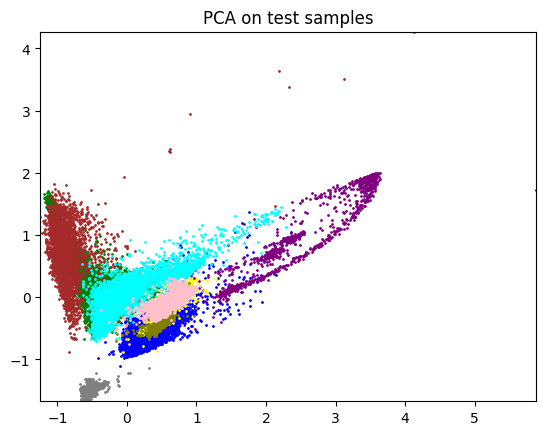

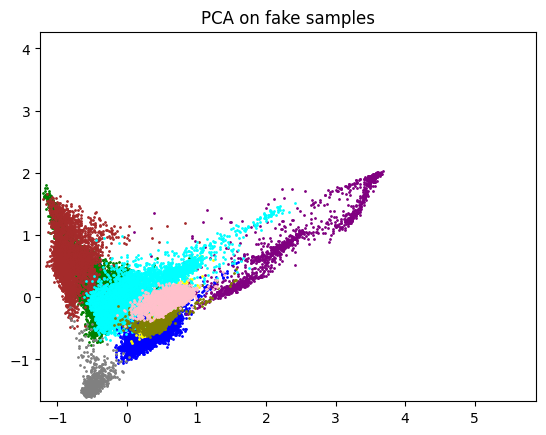

In [34]:
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
x_min, x_max = np.min(X_pca[:,0]), np.max(X_pca[:,0])
y_min, y_max = np.min(X_pca[:,1]), np.max(X_pca[:,1])

colors = ['red', 'blue', 'green', 'yellow', 'brown', 'purple', 'cyan', 'olive', 'pink', 'gray']
for i, color in enumerate(colors):
    idx = y_test == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, s=1)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on test samples')
plt.show()

X_fake_pca = pca.transform(fake_X_test)
for i, color in enumerate(colors):
    idx = fake_y_test == i
    plt.scatter(X_fake_pca[idx, 0], X_fake_pca[idx, 1], s=1, c=color)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on fake samples')
plt.show()

We can train a neural network classifier on the real dataset and the augmented dataset (real + fake).

In [35]:
def train(net, X_train, y_train, epochs=100):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(),
                                             torch.from_numpy(y_train).long())
    loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
    solver = optim.Adam(net.parameters(), amsgrad=True)
    net.train()
    it = 0
    losses = []
    for _ in tqdm(range(epochs)):
        for X, y in loader:
            it += 1
            net.zero_grad()
            X, y = X.cuda(), y.cuda()
            out = net(X)
            loss = F.cross_entropy(out, y)
            loss.backward()
            solver.step()
            losses.append(loss.item())
            if it % 10000 == 0:
                print("Loss at {} = {}".format(it, loss.item()))
                plt.plot(losses) and plt.show()
    return net

 33%|███▎      | 3328/10000 [00:51<01:33, 71.27it/s]

Loss at 10000 = 0.03624216094613075


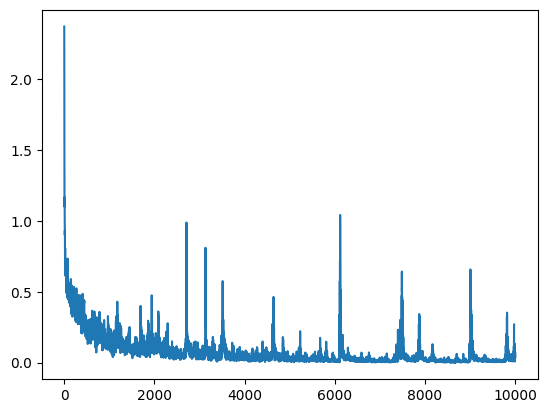

 67%|██████▋   | 6663/10000 [01:43<00:54, 61.28it/s]

Loss at 20000 = 0.0008935654768720269


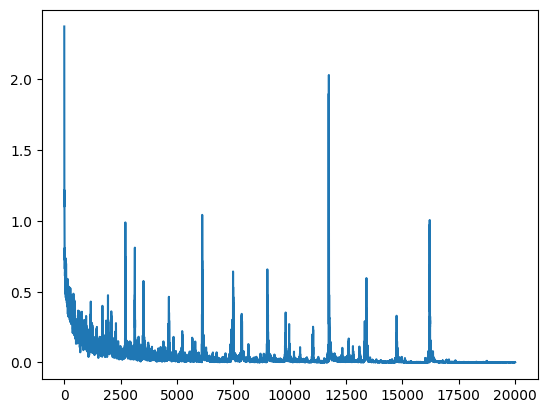

100%|█████████▉| 9993/10000 [02:33<00:00, 62.70it/s]

Loss at 30000 = 0.00016826149658299983


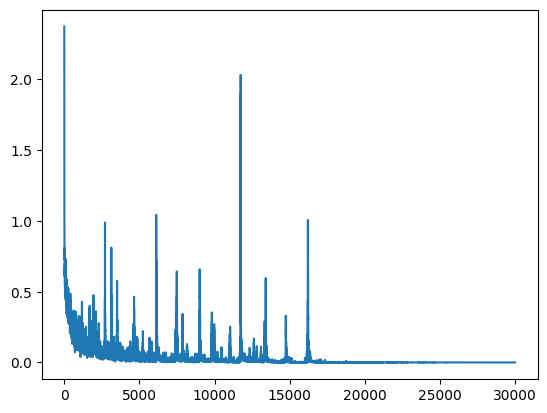

100%|██████████| 10000/10000 [02:34<00:00, 64.91it/s]


In [36]:
C_real = train(Classifier().cuda(), X_train, y_train, epochs=10000)

In [37]:
def test(net, X_test, y_test):
    with torch.no_grad():
        net.eval()
        print(X_test.shape)
        print(y_test.shape)
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(),
                                                 torch.from_numpy(y_test).long())
        loader = torch.utils.data.DataLoader(dataset, batch_size=mb_size)
        pred = []
        for X, y in loader:
            X, y = X.cuda(), y.cuda()
            out = net(X)
            _, out = torch.max(out, 1)
            pred.append(out.cpu().numpy())
        pred = np.concatenate(pred)
        print(classification_report(y_test, pred, digits=4))
    return pred

In [38]:
test(C_real, X_test, y_test)

(40624, 103)
(40624,)
              precision    recall  f1-score   support

           1     0.9392    0.9257    0.9324      6310
           2     0.9706    0.9751    0.9728     17712
           3     0.8255    0.8246    0.8250      1990
           4     0.9502    0.9525    0.9513      2903
           5     0.9882    0.9851    0.9867      1277
           6     0.9131    0.9133    0.9132      4764
           7     0.8542    0.8676    0.8608      1269
           8     0.8662    0.8645    0.8653      3505
           9     1.0000    0.9933    0.9966       894

    accuracy                         0.9390     40624
   macro avg     0.9230    0.9224    0.9227     40624
weighted avg     0.9390    0.9390    0.9390     40624



array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

 20%|█▉        | 1998/10000 [00:57<04:08, 32.26it/s]

Loss at 10000 = 0.0063448743894696236


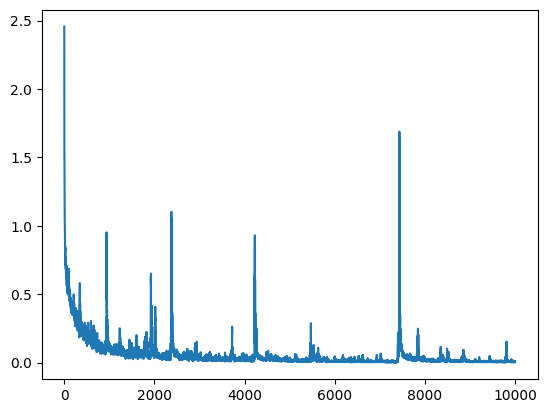

 40%|███▉      | 3997/10000 [01:54<02:40, 37.38it/s]

Loss at 20000 = 0.0007133000181056559


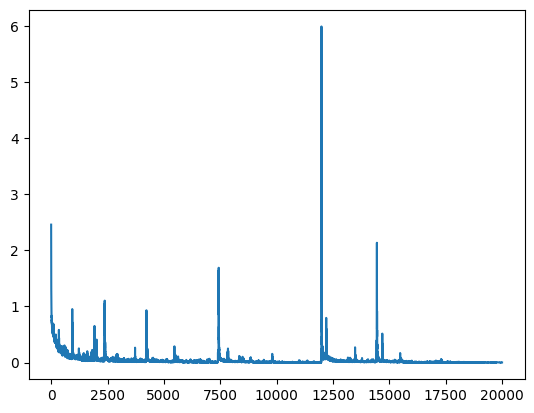

 60%|█████▉    | 5997/10000 [02:52<01:51, 35.90it/s]

Loss at 30000 = 0.00026669944054447114


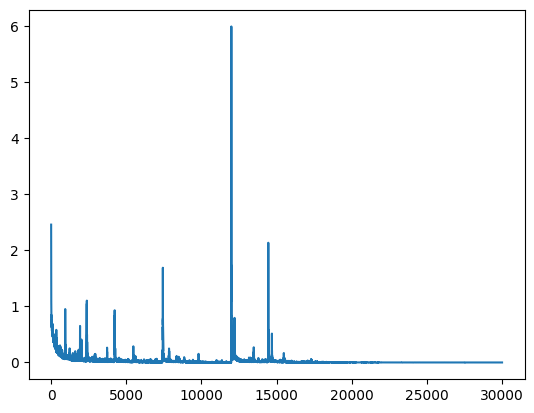

 80%|███████▉  | 7997/10000 [03:51<01:00, 32.85it/s]

Loss at 40000 = 0.00012751767644658685


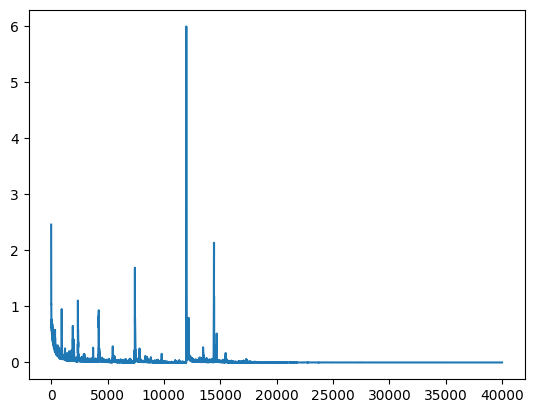

100%|█████████▉| 9998/10000 [04:49<00:00, 36.45it/s]

Loss at 50000 = 7.4405426857993e-05


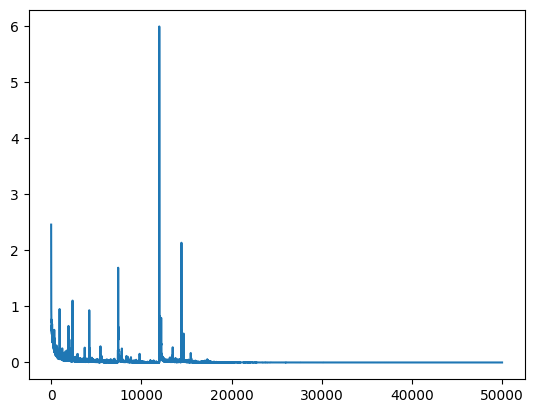

100%|██████████| 10000/10000 [04:49<00:00, 34.58it/s]


In [39]:
C_fake = train(Classifier().cuda(), np.concatenate((X_train, fake_X_train)), np.concatenate((y_train, fake_y_train)), epochs=10000)

The augmented classifier seems to work at least as well as the original one. This is encouraging for using GANs as a data augmentation strategy in a weakly-supervised hyperspectral image classification context.

In [40]:
test(C_fake, X_test, y_test)

(40624, 103)
(40624,)
              precision    recall  f1-score   support

           1     0.9448    0.9469    0.9459      6310
           2     0.9710    0.9775    0.9743     17712
           3     0.8318    0.7925    0.8116      1990
           4     0.9549    0.9556    0.9552      2903
           5     0.9992    0.9789    0.9889      1277
           6     0.9247    0.9177    0.9212      4764
           7     0.9222    0.8684    0.8945      1269
           8     0.8535    0.8776    0.8654      3505
           9     1.0000    0.9955    0.9978       894

    accuracy                         0.9435     40624
   macro avg     0.9336    0.9234    0.9283     40624
weighted avg     0.9434    0.9435    0.9434     40624



array([1, 1, 1, ..., 2, 2, 2], dtype=int64)